## Magnetostratigraphy

In this example, we are going to visualize data from this IODP study: 

> Tauxe, L., Sugisaki, S., Jiménez-Espejo, F., Escutia, C., Cook, C. P., van de Flierdt, T., & Iwai, M. (2015). Geology of the Wilkes Land sub-basin and stability of the East Antarctic Ice Sheet: Insights from rock magnetism at IODP Site U1361. Earth and Planetary Science Letters, 412, 61– 69. https://doi.org/10.1016/j.epsl.2014.12.034

Our goal is to do make a figure that shows the following between the meter levels of 40 and 160 m depth in this core:

- geomagnetic polarity timescale plotted from 2 to 7 Ma
- inclinations (`dir_inc`) from the 20 mT step in the measurements table against depth (let's make them blue dots)
- inclinations (`dir_inc`) from the specimens table against depth (let's make them red triangles)
- lines for the GAD inclination (let's make them dotted)

To start with, we need to get the data from MagIC. We can do this using the DOI of the paper and the `ipmag.download_magic_from_doi()` function to get the data.

## Import the functions we need

In [1]:
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [2]:
ipmag.download_magic_from_doi('10.1016/j.epsl.2014.12.034')

16761/magic_contribution_16761.txt extracted to magic_contribution.txt 



(True, '')

## Download the data

Now that we have got ahold of the MagIC contribution, we can use the `ipmag.download_magic()` function to unpack it into the different MagIC tables. We can either do this into the current directory or specify a specific directory (one of the parameters of the function). Let's just keep the tables in the current directory for this example.

In [3]:
ipmag.download_magic('magic_contribution.txt',print_progress=False)

1  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/contribution.txt
1  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/locations.txt
5943  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/sites.txt
2436  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/samples.txt
2573  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/specimens.txt
4697  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/measurements.txt
60  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/ages.txt


True

## Read in the data tables

Let's import all of the different data tables using `pandas`. For each one, note that we tell pandas that these are tab delimited files `sep='\t'` and that the column names are in the second row (python counts from `0` so this is `header=1`; you can also think of it as skipping 1 header row)

In [4]:
measurements = pd.read_csv('measurements.txt',sep='\t',header=1)
sites = pd.read_csv('sites.txt',sep='\t',header=1)
specimens = pd.read_csv('specimens.txt',sep='\t',header=1)
ages = pd.read_csv('ages.txt',sep='\t',header=1)

Let's take a peek at the data for one of the specimens

-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org


(True, [])

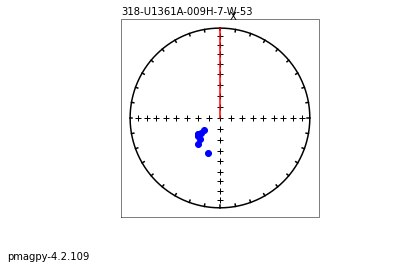

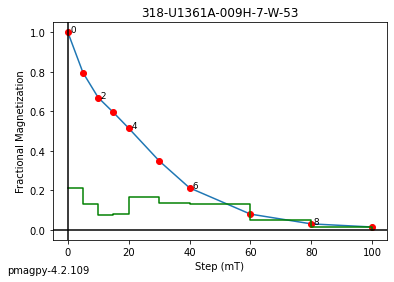

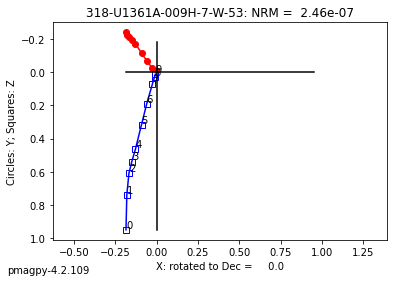

In [5]:
ipmag.zeq_magic(specimen='318-U1361A-009H-7-W-53',save_plots=False)

## Wrangle the data

### Get core depth into every DataFrame

The depth of a particular specimen/site in MagIC is stored in the sites.txt table.  We need to merge the data from that table into the specimens/measurements tables.  To do that we need to do a couple things:

First, we need a common key.  Because the specimen/sample/site names are the same for an IODP record, we can make a column in the specimen/measurements dataframes labled 'site' that is the same as the specimen.  

In [6]:
measurements['site'] = measurements['specimen']
specimens['site'] = specimens['specimen']

Then we can make a depths dataframe with the core_depth information linked to site and merge that information into the specimens and measurements tables with `pd.merge()`

In [7]:
depths = sites[['site','core_depth']]
specimens = pd.merge(specimens,depths,on='site')
measurements = pd.merge(measurements,depths,on='site')

### Filter out the 20 mT step

We are interested in investigating the 20 mT measurement step. We can create a new dataframe that is filtered to be the values in the measurements table where `'treat_ac_field'` is equal to `0.02` (given the MagIC uses SI units so this is 0.02 T which is 20 mT). 

`measurements['treat_ac_field']==0.02` tells us whether a given row has this value in the `'treat_ac_field'` column by giving a True, False list (known as boolean indexing). We can then take the True/False list and tell pandas to give us the values where it is True by putting it inside the `[ ]` index brackets.

In [8]:
measurements_20mT = measurements[measurements['treat_ac_field']==0.02] 

Let's look at the first 5 rows of the filtered data to see that the filtering worked using the `.head()` function applied to the `measurements_20mT` dataframe.

In [9]:
measurements_20mT.head()

,analysts,citations,description,dir_csd,dir_dec,dir_inc,experiment,hyst_charging_mode,hyst_loop,hyst_sweep_rate,instrument_codes,magn_mass,magn_moment,magn_r2_det,magn_uncal,magn_volume,magn_x_sigma,magn_xyz_sigma,magn_y_sigma,magn_z_sigma,meas_field_ac,meas_field_dc,meas_freq,meas_n_orient,meas_orient_phi,meas_orient_theta,meas_pos_x,meas_pos_y,meas_pos_z,meas_temp,meas_temp_change,measurement,method_codes,quality,sequence,software_packages,specimen,standard,susc_chi_mass,susc_chi_qdr_mass,susc_chi_qdr_volume,susc_chi_volume,timestamp,treat_ac_field,treat_ac_field_dc_off,treat_ac_field_dc_on,treat_ac_field_decay_rate,treat_dc_field,treat_dc_field_ac_off,treat_dc_field_ac_on,treat_dc_field_decay_rate,treat_dc_field_phi,treat_dc_field_theta,treat_mw_integral,treat_mw_power,treat_mw_time,treat_step_num,treat_temp,treat_temp_dc_off,treat_temp_dc_on,treat_temp_decay_rate,site,core_depth
0,NaN,This study,NaN,NaN,31.3,-66.1,318-U1361A-001H-2A-0-1-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,2.974000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-1-LT-AF-Z-1,LT-AF-Z,g,1,pmagpy-2.93,318-U1361A-001H_2A-0.1,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.1,1.60
1,NaN,This study,NaN,NaN,44.9,-70.6,318-U1361A-001H-2A-0-15-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,3.071000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-15-LT-AF-Z-1,LT-AF-Z,g,2,pmagpy-2.93,318-U1361A-001H_2A-0.15,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.15,1.65
2,NaN,This study,NaN,NaN,49.7,-69.9,318-U1361A-001H-2A-0-2-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,3.404000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-2-LT-AF-Z-1,LT-AF-Z,g,3,pmagpy-2.93,318-U1361A-001H_2A-0.2,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.2,1.70
3,NaN,This study,NaN,NaN,44.0,-69.3,318-U1361A-001H-2A-0-25-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,4.026000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-25-LT-AF-Z-1,LT-AF-Z,g,4,pmagpy-2.93,318-U1361A-001H_2A-0.25,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.25,1.75
4,NaN,This study,NaN,NaN,52.3,-65.2,318-U1361A-001H-2A-0-3-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,5.061000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-3-LT-AF-Z-1,LT-AF-Z,g,5,pmagpy-2.93,318-U1361A-001H_2A-0.3,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.3,1.80


### Calculate the dipole field

We want to calculate the geocentric axial dipole field for the site latitude. First, we can extract the site latitude. There is only going to be one value as all the data are from the same core.

In [10]:
site_lat = sites['lat'].unique()[0]
site_lat

-64.2457

We can then use the `ipmag` function `ipmag.inc_from_lat()` to use the dipole equation to calculate the expected inclination at this latitude. This is a quite simple function. Let's use the `??` to interogate not only the docstring associated with the function, but the guts inside.

In [11]:
ipmag.inc_from_lat??

Signature: ipmag.inc_from_lat(lat)
Source:   
def inc_from_lat(lat):
    """
    Calculate inclination predicted from latitude using the dipole equation.

    Parameter:
        lat : latitude in degrees

    Returns:
        inclination calculated from latitude using the dipole equation

    Examples:
        Calculate the inclination implied by an latitude of 45 degrees:
        >>> ipmag.inc_from_lat(45)
        63.434948822922
    """
    rad = np.pi/180.0
    inc = np.arctan(2 * np.tan(lat * rad))/rad
    return inc
File:      ~/0000_Github/PmagPy/pmagpy/ipmag.py
Type:      function


If we just run the function, the `inc` gets printed out as notebook output

In [12]:
ipmag.inc_from_lat(site_lat)

-76.43831968696897

In this case, we want to save the value to plot it, so let's assign it to a variable `gad_inc`

In [13]:
gad_inc = ipmag.inc_from_lat(site_lat)

We can then see what the `gad_inc` value is by running a cell with just that variable in it

In [14]:
gad_inc

-76.43831968696897

### Filter ages to be the reversals

There is both biostratigraphic information and interpretations of geomagnetic reversals in the ages table. Let's focus on the `method_codes` that contain `PMAG` information for now.

In [15]:
ages = ages[ages['method_codes'].str.contains('PMAG')]

Let's filter to only look at the ages within the interval of interest between 40 and 160 meters

In [16]:
depth_min = 40
depth_max = 160
ages = ages[(ages['tiepoint_height']<-depth_min)&(ages['tiepoint_height']>-depth_max)]

## Make the figure

### Plot the data

Let's use `plt.scatter()` to plot both the 20 mT measurements and the intepreted specimens data which are fits to the AF demag data.

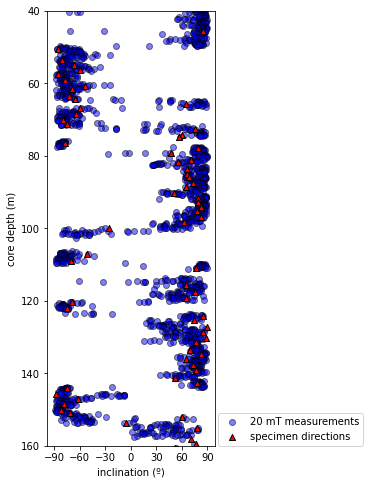

In [17]:
plt.figure(figsize=(3,8))

#plot the measurements as partially transparent blue circles
plt.scatter(measurements_20mT['dir_inc'],
            measurements_20mT['core_depth'],
            c='blue', marker='o', edgecolors='black',alpha=.5,
            label='20 mT measurements')

#plot the interpreted specimen directions as red triangles
plt.scatter(specimens['dir_inc'],
            specimens['core_depth'],
            c='red', marker='^', edgecolors='black',
            label='specimen directions')

plt.xlabel('inclination (º)')
plt.ylabel('core depth (m)')
plt.ylim(depth_max,depth_min)
plt.gca().set_xticks([-90,-60,-30,0,30,60,90])
plt.legend(loc=(1.02,0))
plt.show()

### Plot the Geomagnetic polarity timescale

We want to plot the data with the geomagnetic polarity timescale. We can use the function ```pmagplotlib.plot_ts()``` plot up the GPTS from GTS12.

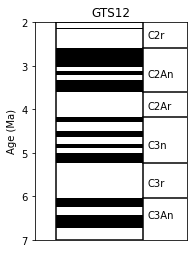

In [18]:
ax1 = plt.subplot(1,2,1)
pmagplotlib.plot_ts(ax1, 2, 7, timescale='gts12')

### Put it all together

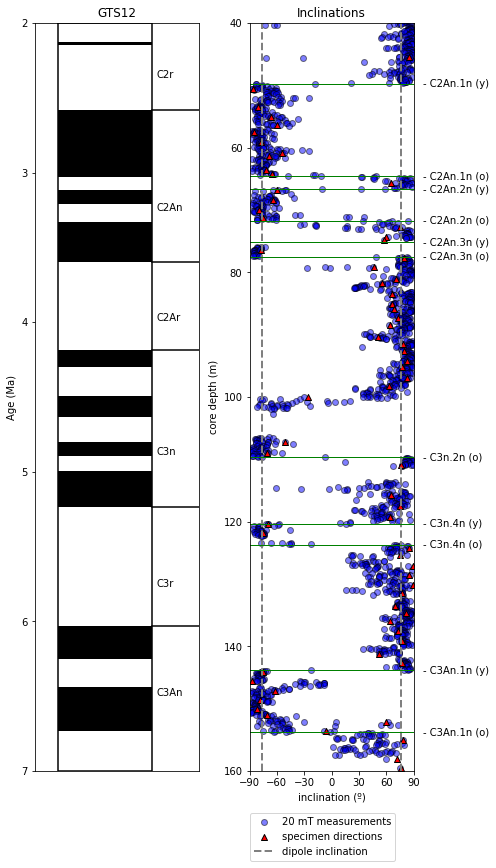

In [34]:
fig = plt.figure(figsize=(7,12)) # make the figure
ax1 = fig.add_subplot(1,2,1) # make the first of two subplots
pmagplotlib.plot_ts(ax1,2,7,timescale='gts12') # plot on the time scale

ax2 = fig.add_subplot(122) # make the second of two subplots
plt.scatter(measurements_20mT['dir_inc'],
            measurements_20mT['core_depth'],
            c='blue', marker='o', edgecolors='black',alpha=.5,
            label='20 mT measurements')
plt.scatter(specimens['dir_inc'],
            specimens['core_depth'],
            c='red', marker='^', edgecolors='black',
            label='specimen directions')

# plot the expected GAD inclination as lines of both polarity
plt.axvline(gad_inc,color='grey',linestyle='dashed',linewidth=2,
            label='dipole inclination')
plt.axvline(-gad_inc,color='grey',linestyle='dashed',linewidth=2)

# plot the age tiepoint values
pmagplotlib.label_tiepoints(ax2,100,ages.tiepoint.values,-1*ages.tiepoint_height.values,lines=True)

plt.legend(loc=(0,-0.12))

ax2.set_xticks([-90,-60,-30,0,30,60,90])
plt.xlabel('inclination (º)')
plt.ylabel('core depth (m)')
plt.title('Inclinations')
plt.ylim(depth_max,depth_min)
plt.xlim(-90,90)
plt.tight_layout()
plt.savefig('IODP_magstrat.pdf')
plt.show()

## Plot anisotropy data

There are abundant anisotropy data that were developed from these samples and that are also within the MagIC file. Let's import a function that calculates the eigenvalues and plots them up. This function is slightly modified from `ipmag.ani_depthplot()`

In [20]:
from ani_functions import ani_depthplot

(<Figure size 792x504 with 5 Axes>, ['U1361A_ani_depthplot.svg'])

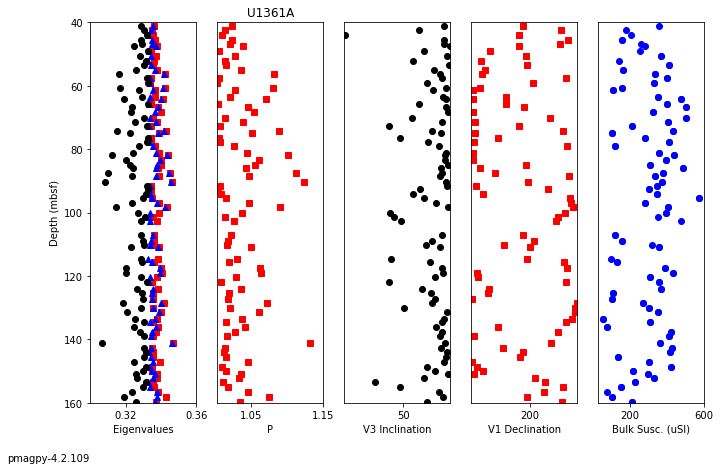

In [21]:
ani_depthplot(dmin=40,dmax=160)